In [1]:
import poison
import torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np
from MiniImagenet import MiniImagenet
from torch.utils.data import DataLoader

In [2]:
learner_model_path = "MiniImagenet_n_way_5_k_shot_5_acc_0.60546875_dateMMDDYYY_10272021"

In [3]:
from Meta import Meta
from Learner import Learner
n_way = 5
miniImgNet_config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [n_way, 32 * 5 * 5])
    ]
model = Learner(miniImgNet_config,3,84)
maml = Meta(miniImgNet_config)
maml.net.load_state_dict(torch.load(f"MiniImagenet_n_way_5_k_shot_5_acc_0.60546875_dateMMDDYYY_10272021",map_location=torch.device('cpu')))
mini_test = MiniImagenet('miniimagenet/', mode='test', n_way=5, k_shot=5,
                         k_query=15,
                         batchsz=100, resize=84)

shuffle DB :test, b:100, 5-way, 5-shot, 15-query, resize:84


In [4]:
# from torchvision.utils import make_grid
# import matplotlib.pyplot as plt
# import patch_utils
# import poison_original

# success = 0
# attempts = 0

# for i, set_ in enumerate(mini_test):

        
#     support_x, support_y, query_x, query_y = set_
#     patch = patch_utils.patch_initialization()
#     applied_patch, mask, x_location, y_location = patch_utils.mask_generation(patch = patch)
#     # print(patch.shape)
#     #support_x, support_y, query_x, query_y
# #     target = query_x[-1]
#     target_class = query_y[-1]
    
# #     maml_for_attack = Meta(miniImgNet_config)
# #      = maml_for_attack
    
#     acc, preq_NP, fast_weights = maml.finetuning(support_x, support_y, query_x, query_y)

#     preq_NP = maml.net(query_x, fast_weights, bn_training=True)
#     _, predicted = torch.max(preq_NP.data, 1)     
    
#     if(predicted[0] == target_class or predicted[0] == query_y[0]):
#         continue
   
#     end_image, end_patch, count = poison_original.patch_attack(query_x, applied_patch,mask,target_class,.8,maml.net,fast_weights, max_iteration=100)
    
#     query_x[0] = torch.from_numpy(end_image)
    
#     preq = maml.net(query_x, fast_weights, bn_training=True)
#     _, predicted = torch.max(preq.data, 1)
#     if(count < 100):
#         attempts += 1
#     print(predicted)
#     print(query_y)
    
#     if(target_class == predicted[0] and count < 100):
#         success+=1
#         print("Success at: ", i)
#         print("Current Success Rate: ", success/attempts)

# print(success/100)

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import patch_utils
import poison
import random

success = 0
attempts = 0
for i, set_ in enumerate(mini_test):
    
    #unsqueeze
    support_x, support_y, query_x, query_y = set_
    support_x, support_y, query_x, query_y = support_x.squeeze(0), support_y.squeeze(0), \
                                 query_x.squeeze(0), query_y.squeeze(0)
    
    # Get a class to poison for all tests
    idx_support = (support_y == 0).nonzero(as_tuple=False)
    idx_query = (query_y == 0).nonzero(as_tuple=False)
    images_to_patch_support = support_x[idx_support]
    images_to_patch_query = query_x[idx_query]
    
    # Create patch and mask and convert to torch
    patch = patch_utils.patch_initialization()
    applied_patch, mask, x_location, y_location = patch_utils.mask_generation(patch = patch)    
    applied_patch = torch.from_numpy(applied_patch)
    mask = torch.from_numpy(mask)
    
    # Add Patch to All Support Data; Try just 1 image, 0 images
    for i, image in enumerate(images_to_patch_support):
        images_to_patch_support[i] = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
    break

    
patch = patch_utils.patch_initialization()
applied_patch, mask, x_location, y_location = patch_utils.mask_generation(patch = patch)
attempts = 0

for i, set_ in enumerate(mini_test):
    
    # pass over task with class
    if(i == 0):
        continue
        
    support_x, support_y, query_x, query_y = set_
    support_x, support_y, query_x, query_y = support_x.squeeze(0), support_y.squeeze(0), \
                             query_x.squeeze(0), query_y.squeeze(0)
    
    # get random position to poison
    target_class = np.random.randint(0, 5)
    
    # set all the support and query
    idx_support = (support_y == target_class).nonzero(as_tuple=False)
    idx_query = (query_y == target_class).nonzero(as_tuple=False)
    query_attack_idx = idx_query[np.random.randint(0, len(idx_query))]
    
    for j, idx in enumerate(idx_support):
        support_x[idx] = images_to_patch_support[j]
    
    for j, idx in enumerate(idx_query):
        query_x[idx] = images_to_patch_query[j]
            
    
    # get acc and fast weights for the 
    acc, preq_NP, fast_weights = maml.finetuning(support_x, support_y, query_x, query_y) 

    if(i < 60):
        print(i)
        end_image, end_patch, count = poison.patch_attack(query_x, applied_patch,mask,target_class,query_attack_idx, 0.1,maml.net,fast_weights)

        applied_patch = end_patch

        query_x[query_attack_idx] = torch.from_numpy(end_image)

#     if(target_class != predicted[query_attack_idx]):
#         continue
    
    applied_patch_1 = torch.from_numpy(applied_patch)
    mask_1 = torch.from_numpy(mask)
    query_x[query_attack_idx] = torch.mul(mask_1.type(torch.FloatTensor), applied_patch_1.type(torch.FloatTensor)) + torch.mul((1 - mask_1.type(torch.FloatTensor)), query_x[query_attack_idx].type(torch.FloatTensor)) 
    
    
    preq = maml.net(query_x, fast_weights, bn_training=True)
    _, predicted = torch.max(preq.data, 1)
    print(i)
    print("idx: ", query_attack_idx)
    print(predicted[query_attack_idx])
    print(query_y[query_attack_idx])
    print(predicted[query_attack_idx]==query_y[query_attack_idx])
    print(count)
    
    if(i >= 60):
        attempts += 1
    
    if(target_class != predicted[query_attack_idx] and i >= 60):
        success+=1
        print("Success at: ", i)
        print("Current Success Rate: ", success/attempts)

print(success/100)

1


/Users/Neel/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


1
idx:  tensor([3])
tensor([0])
tensor([1])
tensor([False])
5
2
2
idx:  tensor([49])
tensor([3])
tensor([2])
tensor([False])
100
3
3
idx:  tensor([48])
tensor([1])
tensor([2])
tensor([False])
6
4
4
idx:  tensor([66])
tensor([4])
tensor([4])
tensor([True])
100
5
5
idx:  tensor([71])
tensor([3])
tensor([0])
tensor([False])
31
6
6
idx:  tensor([9])
tensor([0])
tensor([2])
tensor([False])
5
7
7
idx:  tensor([33])
tensor([1])
tensor([3])
tensor([False])
1
8
8
idx:  tensor([68])
tensor([3])
tensor([2])
tensor([False])
45
9
9
idx:  tensor([63])
tensor([3])
tensor([2])
tensor([False])
1
10
10
idx:  tensor([0])
tensor([3])
tensor([1])
tensor([False])
11
11
11
idx:  tensor([71])
tensor([4])
tensor([1])
tensor([False])
1
12
12
idx:  tensor([11])
tensor([2])
tensor([0])
tensor([False])
5
13
13
idx:  tensor([55])
tensor([0])
tensor([0])
tensor([True])
100
14
14
idx:  tensor([61])
tensor([1])
tensor([1])
tensor([True])
100
15
15
idx:  tensor([10])
tensor([2])
tensor([2])
tensor([True])
100
16
16
idx

In [6]:
print(i)

99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 84, 84])


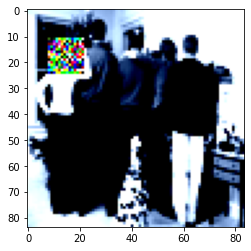

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


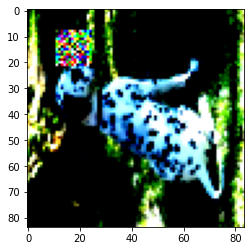

In [26]:
patch = patch_utils.patch_initialization()
applied_patch, mask, x_location, y_location = patch_utils.mask_generation(patch = patch)
from matplotlib import pyplot as plt
# end_image.T
print(images_to_patch_support[2].size())
# plt.imshow(images_to_patch_support[0][1].permute(1, 2, 0), interpolation='nearest')
plt.show()
plt.imshow(query_x[query_attack_idx][0].permute(1, 2, 0))
plt.show()
plt.imshow(end_image.T)
plt.show()

In [8]:
import patch_utils
import poison
patch = patch_utils.patch_initialization()
applied_patch, mask, x_location, y_location = patch_utils.mask_generation(patch = patch)
# print(patch.shape)
#support_x, support_y, query_x, query_y
target = query_x[-1]
target_class = query_y[-1]
# # print(patch)
# # print(mini_test[0])
# print(applied_patch.shape)
# print(query_x[0].size())
# print((1-(torch.from_numpy(mask)).type(torch.FloatTensor)).size())
# print(query_x[0].type(torch.FloatTensor).size())
# print(torch.mul((1-(torch.from_numpy(mask)).type(torch.FloatTensor)), (query_x[0].type(torch.FloatTensor))))
# # print((*(torch.from_numpy(applied_patch)).type(torch.FloatTensor)))
# # print(applied_patch.tolist())
# # print((torch.from_numpy(applied_patch)).type(torch.FloatTensor))
# # print((torch.from_numpy(applied_patch)).type(torch.FloatTensor) + torch.mul((1-(torch.from_numpy(mask)).type(torch.FloatTensor)), (query_x[0].type(torch.FloatTensor))))
end_image, end_patch = poison.patch_attack(query_x, applied_patch,mask,target_class,.8,maml.net )#'rectangle', target, patch, mini_test,maml.net)

TypeError: patch_attack() missing 2 required positional arguments: 'model' and 'fast_weights'

In [ ]:
from matplotlib import pyplot as plt
# end_image.T
plt.imshow(end_image.T, interpolation='nearest')
plt.show()
plt.imshow(query_x[0].permute(1, 2, 0))
plt.show()


In [ ]:
query_x[0] = torch.from_numpy(end_image)
acc, preq = maml.finetuning(support_x, support_y, query_x, query_y)

In [ ]:
print(preq)
print(query_y)
print(target_class)

In [20]:
acc

array([0.4       , 0.52      , 0.56      , 0.53333333, 0.53333333,
       0.53333333, 0.54666667, 0.54666667, 0.54666667, 0.53333333,
       0.53333333])

0.013333333333333334